In [16]:
import sys

sys.path.append(
    "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab3-velocity-modeling/Velocity_Modeling"
)

# all the stuff that needs to be imported
import pandas as pd
import numpy as np
from numpy import sin, cos, pi, arctan2, sqrt

# from numpy import degrees as r2d
from numpy import radians as d2r
from matplotlib import pyplot as plt
import pygmt  # only for some fancy plots to start

# Savage and Buford original model

For an infinitely long strike-slip fault, the fault parallel displacement away from a locked fault in $x$ is:
$$ U_{FP}(x) = \frac{v}{\pi} \tan^{-1}(\frac{x}{W}) $$

where $v$ is the slip rate, $W$ is the down-dip width of the fault from the surface.


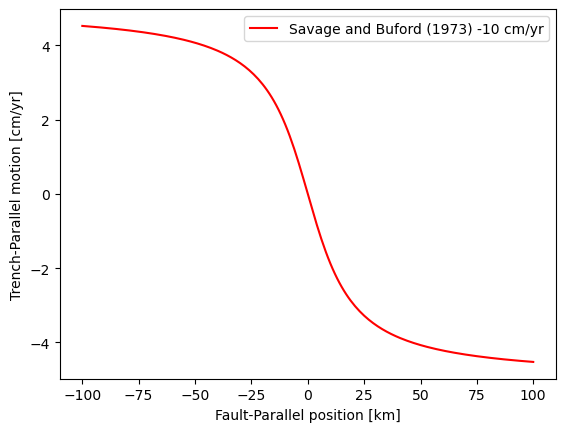

In [17]:
x = np.linspace(-100, 100, 201)
W = 15
D = -10  # cm/yr? Neg for Right-Lateral
Ufp = D / pi * arctan2(x, W)
plt.plot(x, Ufp, "r-", label="Savage and Buford (1973) -10 cm/yr")
plt.xlabel("Fault-Parallel position [km]")
plt.ylabel("Trench-Parallel motion [cm/yr]")
plt.legend()
plt.show()


In [18]:
# read local file.
GPS_all = pd.read_csv(
    "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab3-velocity-modeling/Velocity_Modeling/cwu.final_nam14.vel",
    delim_whitespace=True,
    skiprows=35,
)
# read directly from source
# VELS=pd.read_csv('https://gage-data.earthscope.org/archive/gnss/products/velocity/cwu.final_nam14.vel', delim_whitespace=True, skiprows=35)
GPS_all.rename(
    columns={
        "*Dot#": "ID",
        "Ref_Elong": "Lon",
        "Ref_Nlat": "Lat",
        "Ref_Up...": "Elev",
        "dE/dt": "Evel",
        "dN/dt": "Nvel",
        "dU/dt": "Uvel",
    },
    inplace=True,
)
GPS = GPS_all[
    [
        "ID",
        "Lon",
        "Lat",
        "Elev",
        "Evel",
        "Nvel",
        "Uvel",
        "SEd",
        "SNd",
        "SUd",
        "Rne",
        "Rnu",
        "Reu",
        "Ref_epoch",
        "first_epoch",
        "last_epoch",
    ]
].copy()
GPS["Lon"] = GPS["Lon"] - 360.0  # make lons negative

# remove duplicates, keeping only the latest
GPS = GPS.drop_duplicates(subset=["ID"], keep="last").reset_index(drop=True)

GPS.shape  # how many vectors?

(2194, 16)

In [19]:
# subset for region
region = [-125, -118, 35, 40]

# only keep those within region.
GPS = GPS[
    (
        (GPS["Lat"] > region[2])
        & (GPS["Lat"] < region[3])
        & (GPS["Lon"] > region[0])
        & (GPS["Lon"] < region[1])
    )
]
print(GPS.shape)  # how many vectors now?

(299, 16)


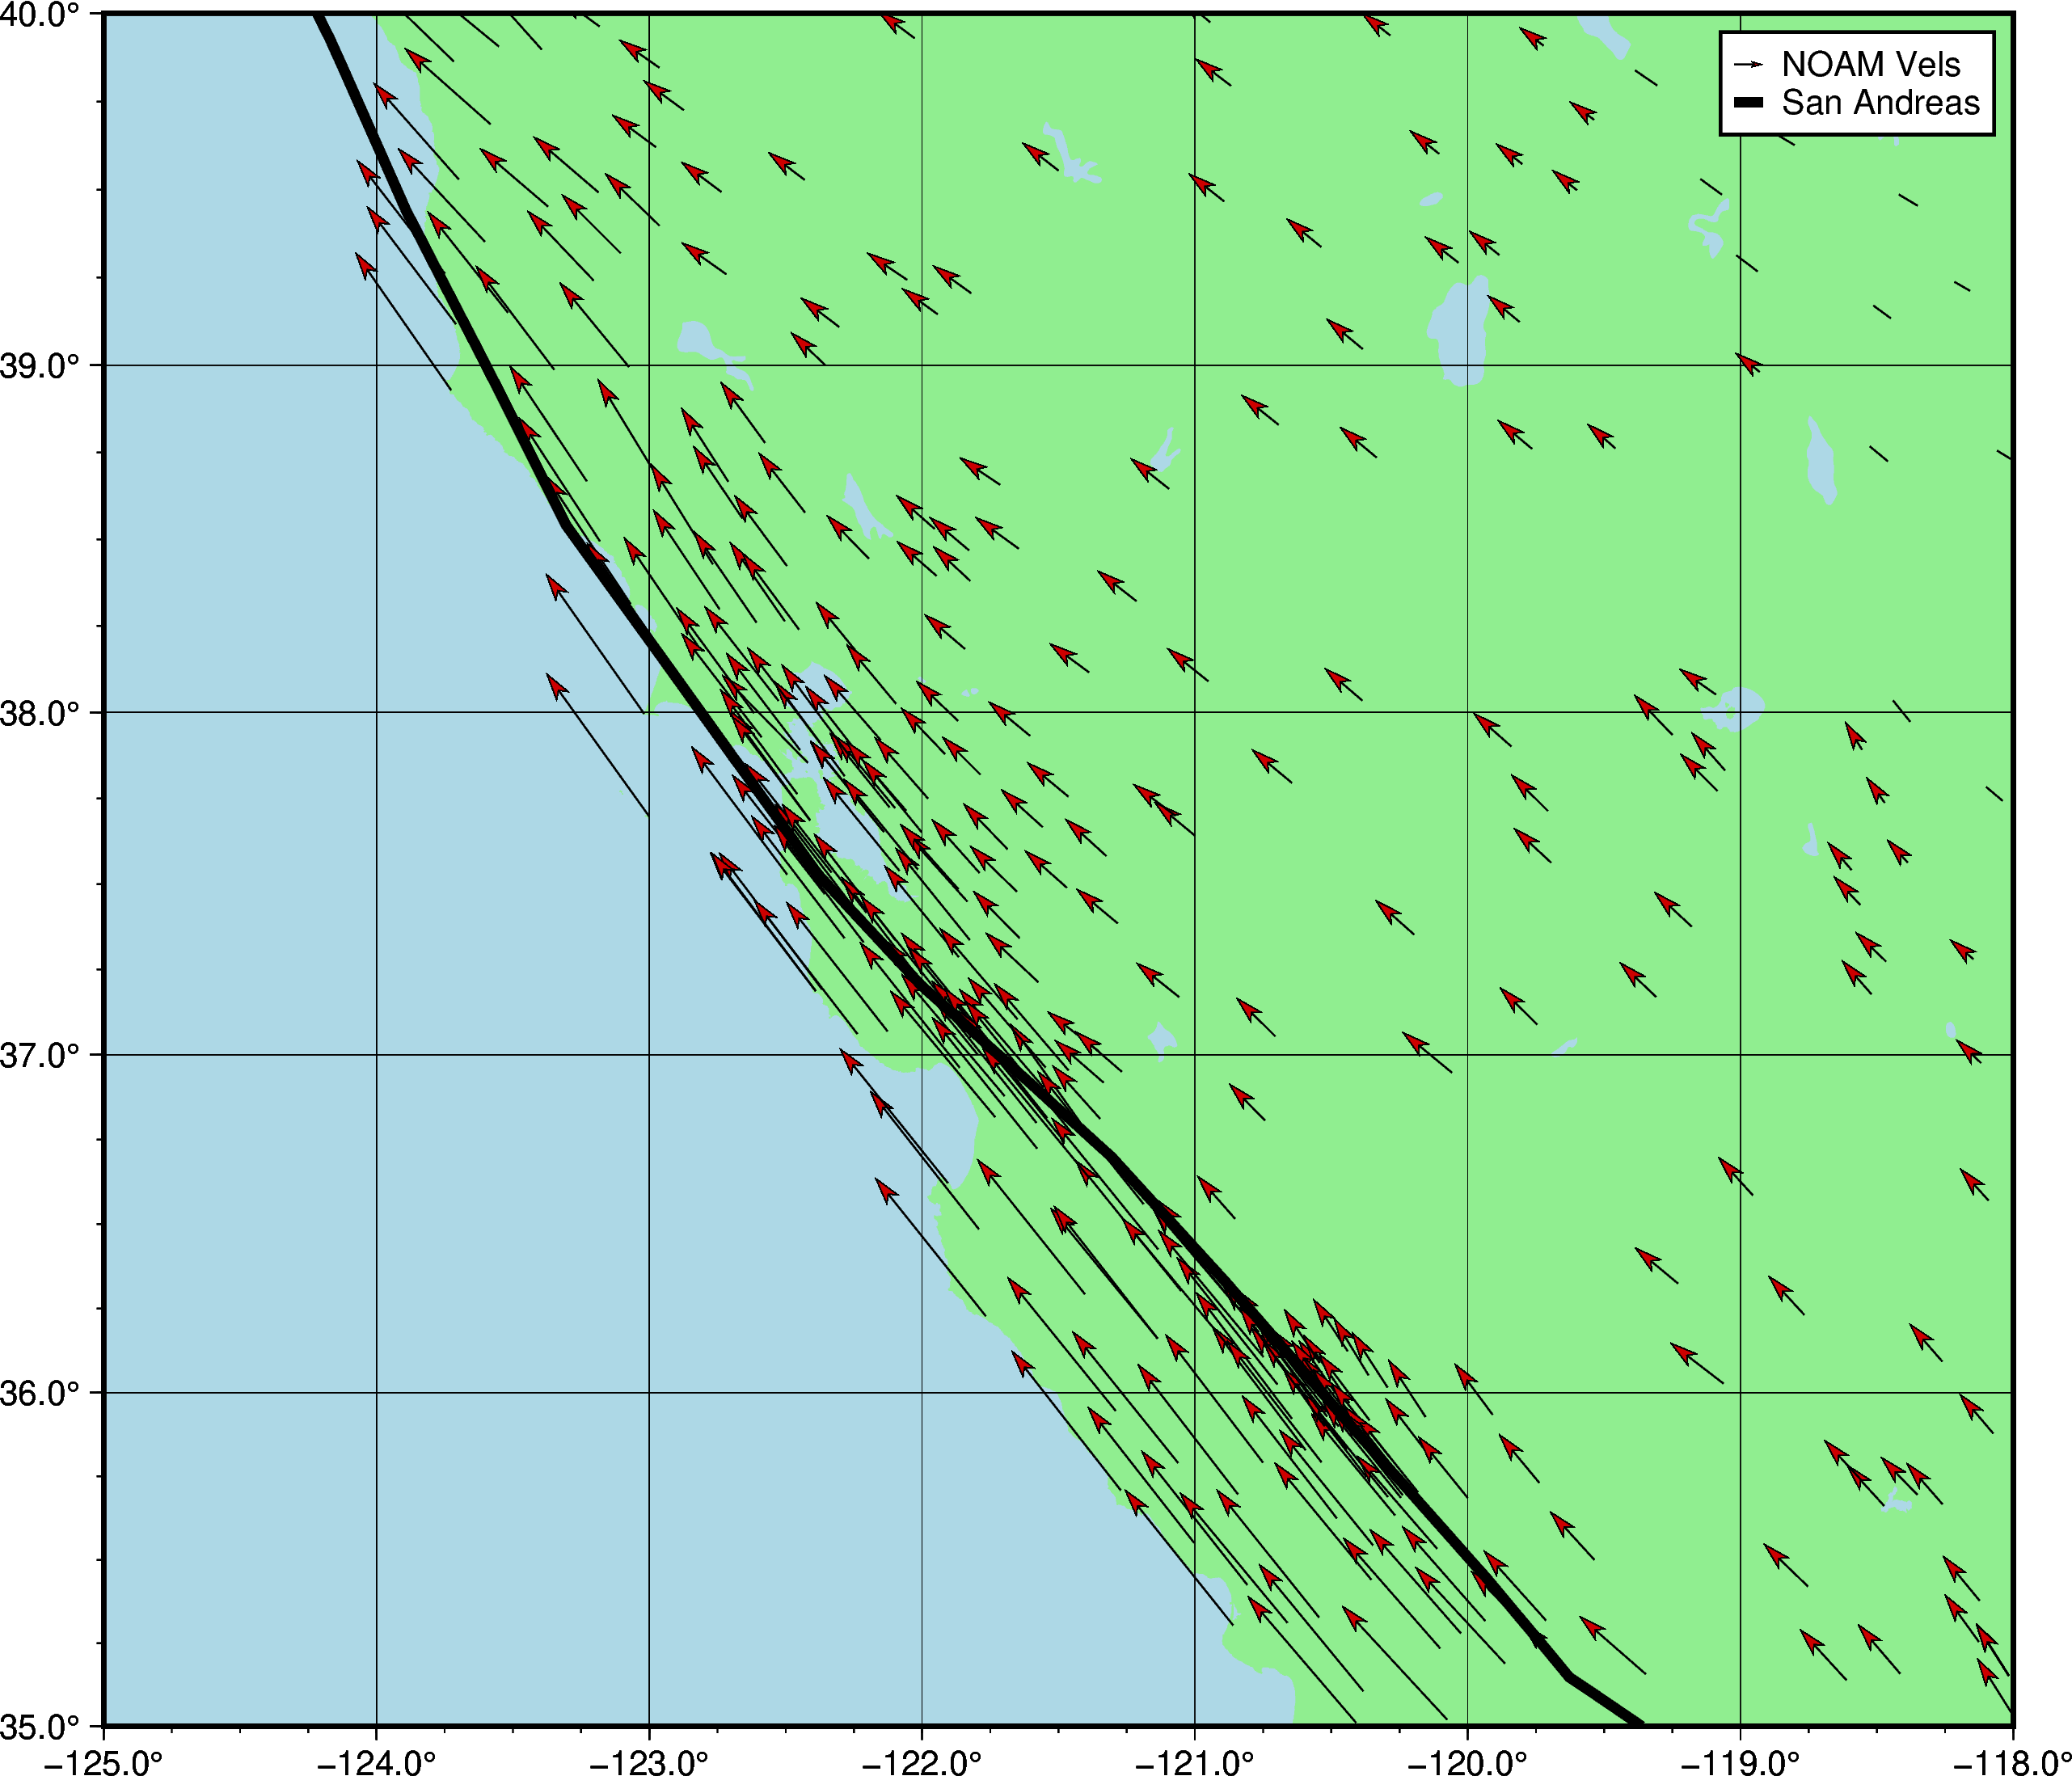

In [20]:
# plot vectors in geographic reference
# If you'd like a plot like this, you will need to install 'pygmt'.
# To do so, you could follow my instructions (and tutorial) below
# .  https://github.com/avnewman/pyGMT-Tutorial
fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_TYPE="plain",  # no alternating B&W
    FORMAT_GEO_MAP="ddd.x",
)  # decimal degrees
fig.coast(
    region=region, projection="M20c", land="lightgreen", water="lightblue", frame="ag"
)

# reformat velocities into scaled solutions that can be used for pyGMT plotting
scalevels = 40
dirs = [
    180 / pi * arctan2(GPS["Nvel"], GPS["Evel"]),
    scalevels * sqrt(GPS["Evel"] ** 2 + GPS["Nvel"] ** 2),
]
fig.plot(
    x=GPS["Lon"],
    y=GPS["Lat"],
    direction=dirs,
    frame="afg",
    style="v0.3c+e",
    pen="0.5p",
    fill="red3",
    label="NOAM Vels",
)
### add San Andreas Fault
safFile = "/Users/winniechu/Documents/Teaching/Geophysics/2024/lab/lab3-velocity-modeling/Velocity_Modeling/SAF.xy"
saf = np.loadtxt(safFile, comments="#")
fig.plot(data=saf, pen="3p,black", label="San Andreas")
fig.legend()
fig.show()

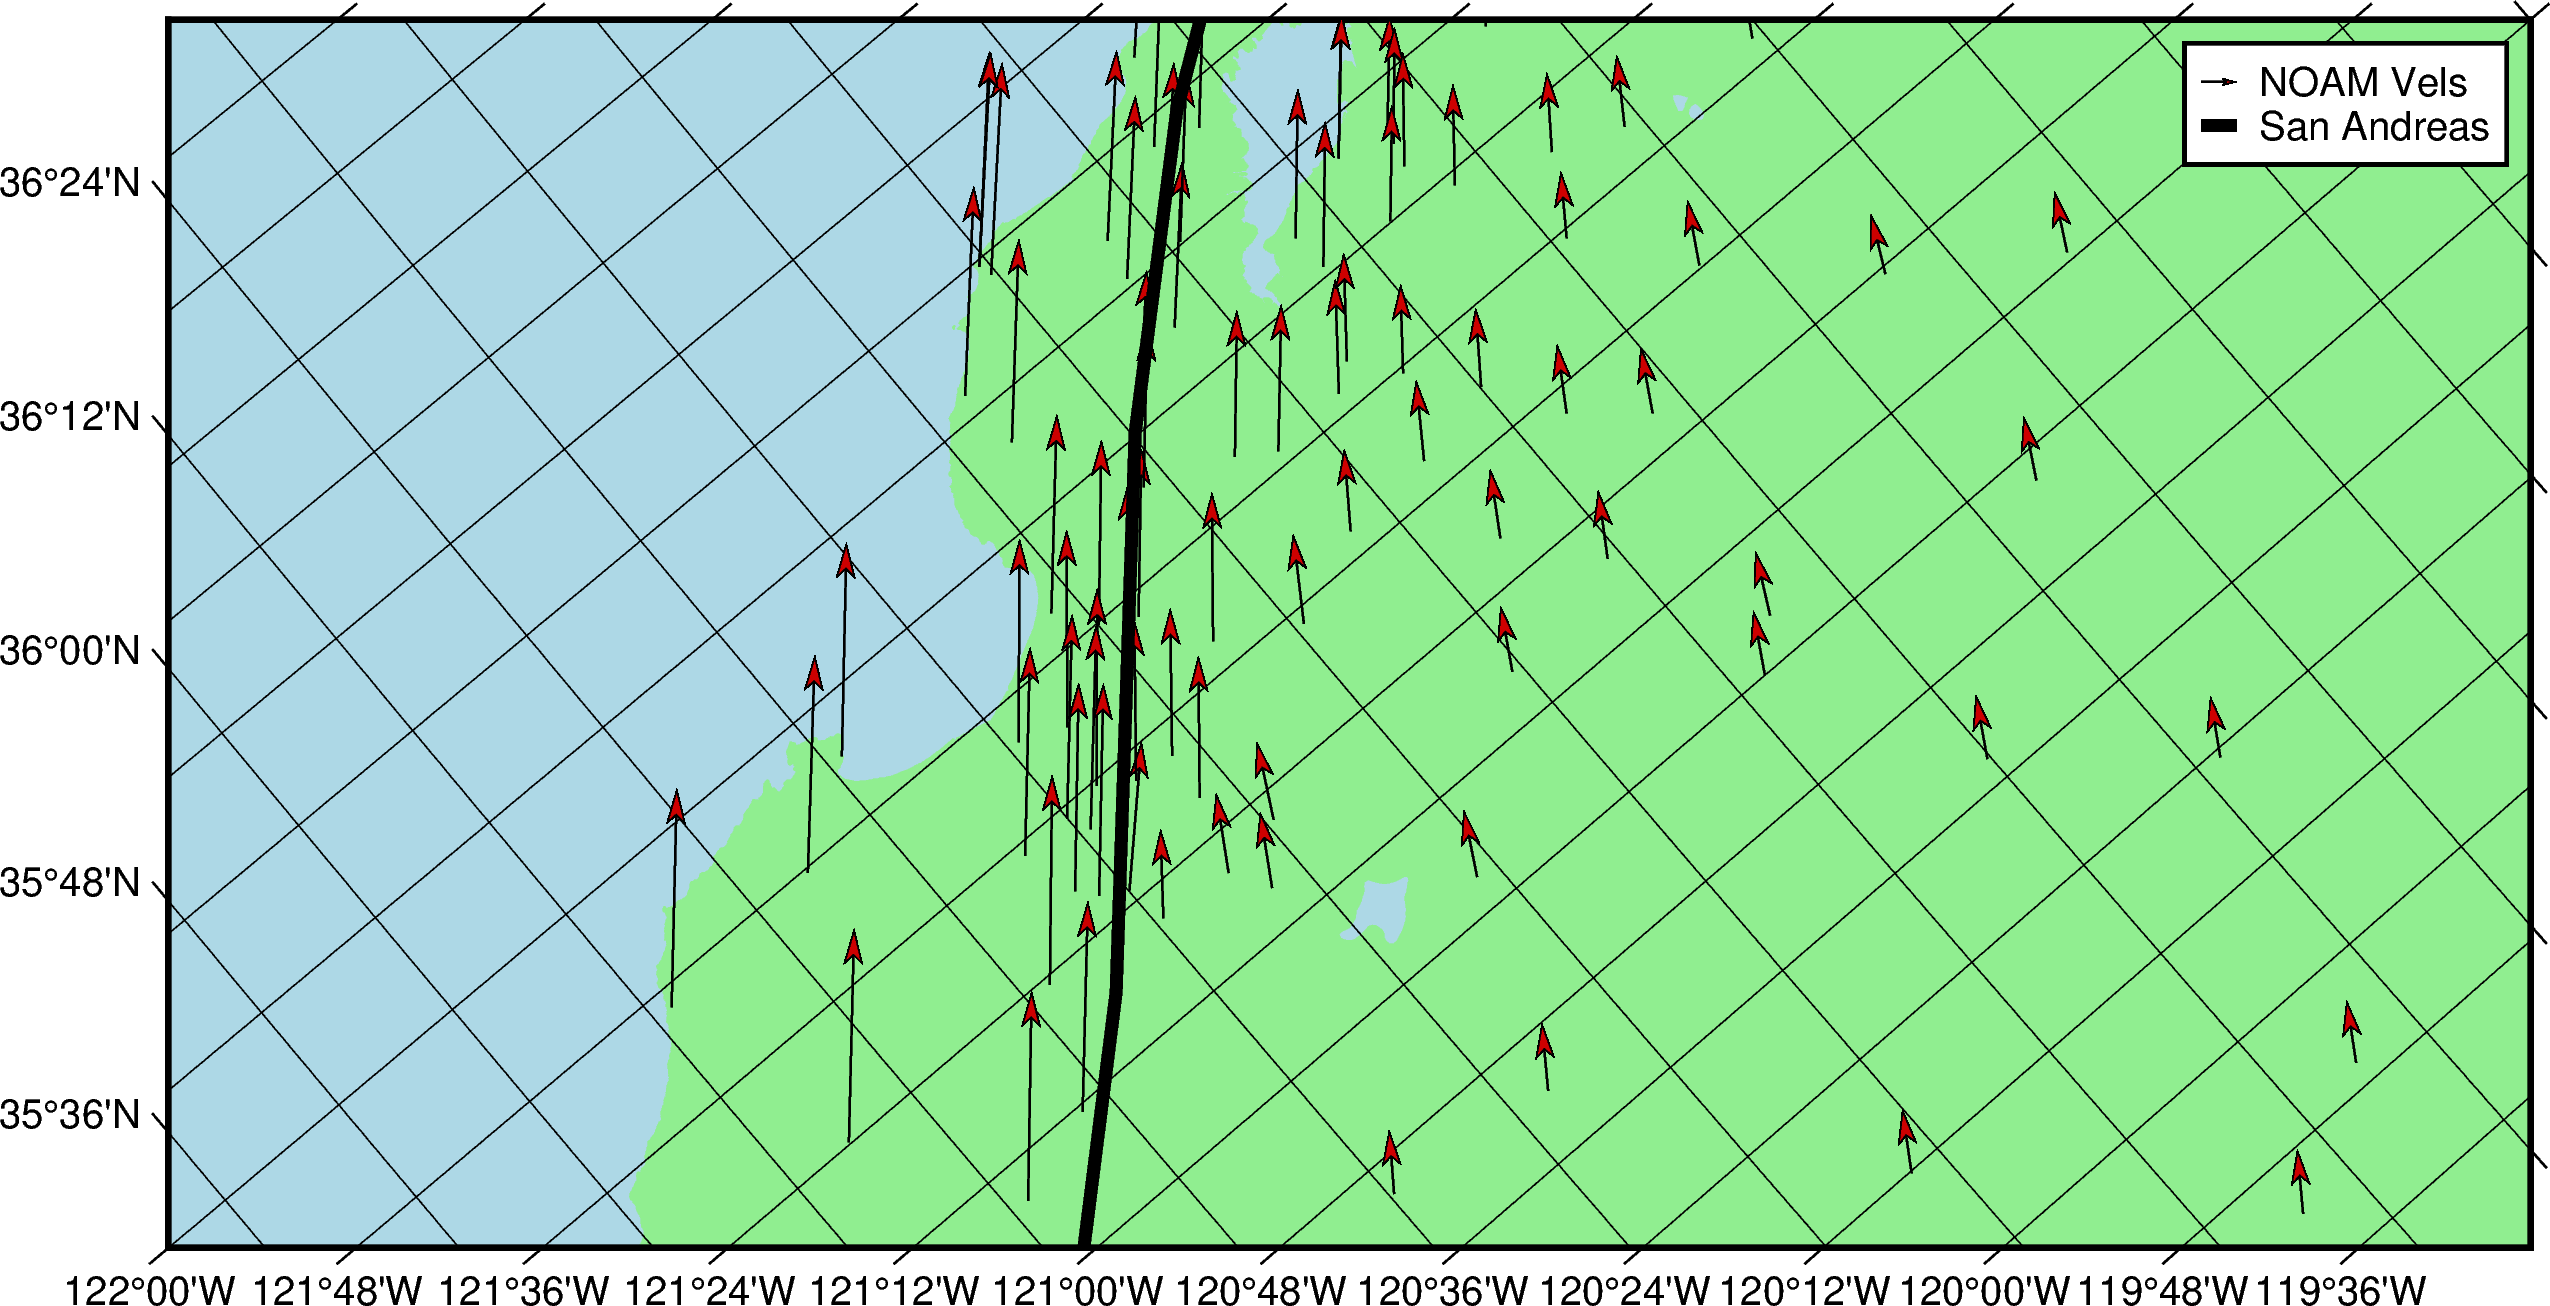

In [21]:
# plot vectors rotated relative to the San Andreas Fault
# find a good rotation and grouping of data
pygmt.config(
    MAP_FRAME_TYPE="plain",  # no alternating B&W
    FORMAT_GEO_MAP="ddd.x",
)  # decimal degrees
rot = 40
BL = [-122, 35.5]
TR = [-121, 39]  # rotation, Bottom-Left and Top-Right
rfig = pygmt.Figure()
rfig.coast(
    projection="Oa" + str(BL[0]) + "/" + str(BL[1]) + "/" + str(rot) + "/20c",
    region=str(BL[0]) + "/" + str(BL[1]) + "/" + str(TR[0]) + "/" + str(TR[1]) + "+r",
    land="lightgreen",
    water="lightblue",
    frame=["SWen", "xa.2g.2", "ya.2g.2"],
)
# vectors don't rotate with :(
rdirs = dirs.copy()
rdirs[0] = rdirs[0] - rot
rfig.plot(
    x=GPS["Lon"],
    y=GPS["Lat"],
    direction=rdirs,
    style="v0.3c+e",
    pen="0.5p",
    fill="red3",
    label="NOAM Vels",
)
rfig.plot(data=saf, pen="3p,black", label="San Andreas")

rfig.legend()
rfig.show()

In [22]:
# Create rotation routine
def ll2xykm(lon, lat, lon0, lat0, rot):
    """
    Converts lat and lon data into local xy [m scale] using an origin
    location and rotation (in degrees).

    Modified from our Matlab program in GTDef, first written by Undergrad
    Amanda Thomas (Now faculty at Univ. Oregon) and Grad Student Lujia Feng
    Now faculty at EOS, Singaore).
    """
    Rearth = 6378.137  # R - Earth's radius at equator [km]
    flattening = 1 / 298.257  # (a-b)/a factor
    R0 = Rearth * (1 - flattening * sin(d2r(lat0)) ** 2)  # Radius at local latitude

    # transform from lon,lat to xx,yy using (lon0,lat0) as origin
    yy = R0 * pi / 180 * (lat - lat0)
    xx = R0 * pi / 180 * (lon - lon0) * cos(d2r(lat0))
    # rotate the coordinate system by rot [degree]
    x_rot = xx * cos(d2r(rot)) + yy * sin(d2r(rot))
    y_rot = -xx * sin(d2r(rot)) + yy * cos(d2r(rot))
    return x_rot, y_rot


# get rotated local coordinates
GPS["X"], GPS["Y"] = ll2xykm(GPS["Lon"], GPS["Lat"], BL[0], BL[1], rot)  # in km

# get velocities in local coords (we're going to ignore errors :( )
GPS["Xvel"] = GPS["Evel"] * cos(d2r(rot)) + GPS["Nvel"] * sin(d2r(rot))
GPS["Yvel"] = -GPS["Evel"] * sin(d2r(rot)) + GPS["Nvel"] * cos(d2r(rot))

# keep only data within rectangle
GPSend = ll2xykm(TR[0], TR[1], BL[0], BL[1], rot)  # end point for subsetting
GPSl = (
    GPS[
        (
            (GPS["X"] > 0)
            & (GPS["X"] < GPSend[0])
            & (GPS["Y"] > 0)
            & (GPS["Y"] < GPSend[1])
        )
    ]
    .copy()
    .reset_index(drop=True)
)
FltXY = ll2xykm(-121, 36.42, BL[0], BL[1], rot)
fltOffset = FltXY[0]

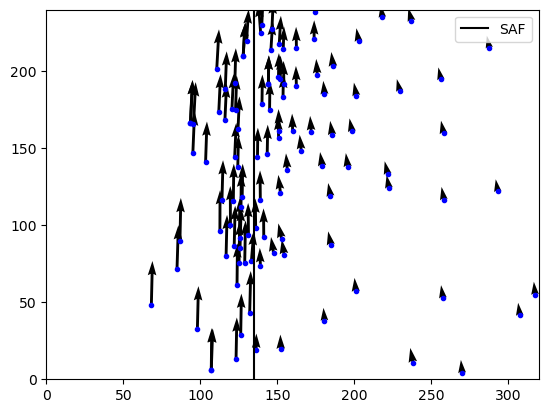

In [23]:
# plot results to make sure transformation is good
plt.plot(GPSl["X"], GPSl["Y"], "b.")
plt.xlim([0, GPSend[0]])
plt.ylim([0, GPSend[1]])
plt.quiver(GPSl["X"], GPSl["Y"], GPSl["Xvel"], GPSl["Yvel"])
plt.plot([fltOffset, fltOffset], [0, GPSend[1]], "k-", label="SAF")
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

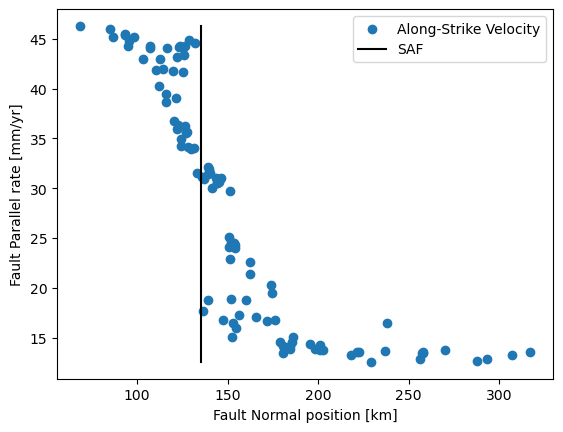

In [24]:
# replot as a simple 1D transect
plt.scatter(x=GPSl["X"], y=GPSl["Yvel"] * 1e3, label="Along-Strike Velocity")
plt.plot(
    [fltOffset, fltOffset],
    [min(GPSl["Yvel"]) * 1e3, max(GPSl["Yvel"]) * 1e3],
    "k-",
    label="SAF",
)
plt.xlabel("Fault Normal position [km]")
plt.ylabel("Fault Parallel rate [mm/yr]")
plt.legend()
plt.show()

In [25]:
# prep for inversion

# prep data vector
# Velocities in y-direction (in mm/yr)
v = np.array([GPSl["Yvel"] * 1e3]).T  # creates column vector

# model depths
depths = np.array([5, 10, 20])

# build Coefficient Matrix
# Apply Savage and Buford Depth of Locking Model
# for v = a - slips/pi *arctan2(x,dl)
# solving for 'a', and 'slips' over range of data
# described by position across fault (x)

n = len(v)  # number of data points
p = 1 + len(depths)  # offset + slip at locking 3 depths

x = GPSl["X"] - fltOffset  # position relative to fault (number of data)
A = np.ones((n, p))  # create matrix of 1s
# first column is the offset 'a' so the coefficient will be 1.
# other 4 columns are for depth-dependent slip values

j = 1
for depth in depths:  # this will only step to 25-5 (20)
    A[:, j] = np.array(-1 / pi * arctan2(x, depth))
    j = j + 1

# print(A.shape)
# print(A)

## Inversion
run linear least-squares inversion following methods described in last class

The inversion equation is:
$$ m = (A^T A)^{-1} A^T d $$

It could be further written with the dedicated inversion matrix, $A^*$:

$$ A^* = (A^T A)^{-1} A^T $$

such that:
$$ m = A^* d$$

In [26]:
# inversion
Astar = np.linalg.inv(A.T.dot(A)).dot(A.T)
model = Astar.dot(v)
print(model)  # remember that the offset is the first parameter


[[ 31.81471855]
 [ 20.18788265]
 [-40.20923088]
 [ 62.53049206]]


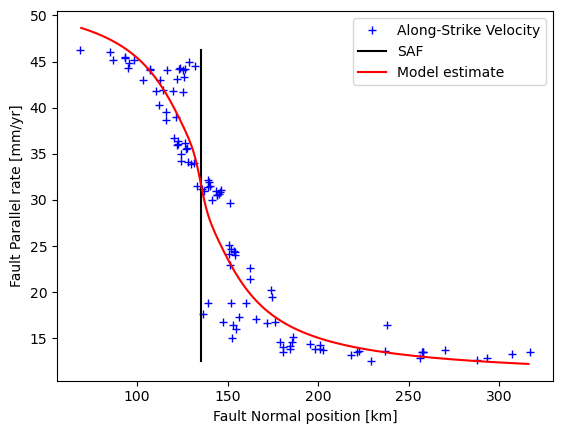

In [27]:
# replot as a simple 1D transect
plt.plot(GPSl["X"], GPSl["Yvel"] * 1e3, "b+", label="Along-Strike Velocity")
plt.plot([fltOffset, fltOffset], [min(v), max(v)], "k-", label="SAF")
plt.xlabel("Fault Normal position [km]")
plt.ylabel("Fault Parallel rate [mm/yr]")

xrange = np.array(list(range(int(min(x)), int(max(x))))) + fltOffset
v_est = model[0] * np.ones(len(xrange))
for j in range(1, len(model)):
    v_est = v_est - model[j] / pi * arctan2(xrange - fltOffset, depths[j - 1])

plt.plot(xrange, v_est, "r-", label="Model estimate")
plt.legend()
plt.show()

# Putting it all together

## First, lets redo some of the above work as functions
1. pred_locking, with predict the velocities for a specific set of model parameters
2. inv_locking, will take given velocities and use it to invert for a specific set of model parameters. This will optionally report and plot results

In [28]:
# All now as a function
def pred_locking(x, mparams, depths):
    """
    given x=locations, mparams=model parameters and
    depth=depths of locking, predict model solutions for velocity
    """
    v_est = mparams[0] * np.ones(len(x))
    for j in range(1, len(mparams)):
        v_est = v_est - mparams[j] / pi * arctan2(x, depths[j - 1])
    return v_est


def inv_locking(data, x, fltOffset, depths, report=True, plot=False):
    n = len(data)  # number of data points
    p = 1 + len(depths)  # offset + slip at locking 3 depths
    A = np.ones((n, p))  # create matrix of 1s
    j = 1
    for depth in depths:  # this will only step to 25-5 (20)
        A[:, j] = np.array(-1 / pi * arctan2(x, depth))
        j = j + 1
    Astar = np.linalg.inv(A.T.dot(A)).dot(A.T)
    model = Astar.dot(data)

    v_est = pred_locking(x, model, depths)
    ms = 0
    for i in range(1, n):
        ms = ms + (data[i] - v_est[i]) ** 2
    ms = ms / n  # mean-squared
    rms = float(sqrt(ms))  # root-mean-squared
    if report:
        print("Velocity offset, a = %.1f [mm/yr]" % (model[0]))
        i = 0
        for param in model[1:]:
            print("at 0-%d [km] depth, slip rate is %.1f [mm/yr]" % (depths[i], param))
            i = i + 1
        print("RMS error is %.2f mm/yr\n" % (rms))

    if plot:
        plt.plot(x + fltOffset, data, "b+", label="Along-Strike Velocity")
        plt.plot([fltOffset, fltOffset], [min(data), max(data)], "k-", label="SAF")
        plt.xlabel("Fault Normal position [km]")
        plt.ylabel("Fault Parallel rate [mm/yr]")
        xrange = np.array(list(range(int(min(x)), int(max(x))))).T
        vrange_est = pred_locking(xrange, model, depths)
        plt.plot(xrange + fltOffset, vrange_est, "r-", label="Model estimate")
        plt.legend()
        plt.show()

    return model, rms

Velocity offset, a = 31.5 [mm/yr]
at 0-15 [km] depth, slip rate is 37.3 [mm/yr]
RMS error is 3.68 mm/yr



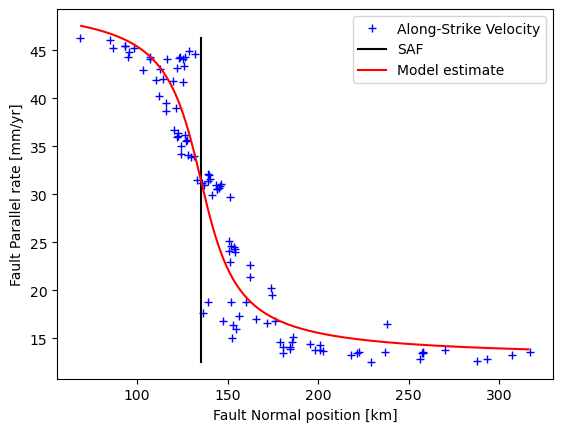

In [29]:
# run for an inital test
depth = [15]
model = inv_locking(v, x, fltOffset, depth, report=True, plot=True)

### Maybe re-evaluate our model.
It looks like there is some diversity in behavior across the model.
Maybe split the data into 2 groups.

First step is to look at the data along strike and see if there are clear differences.

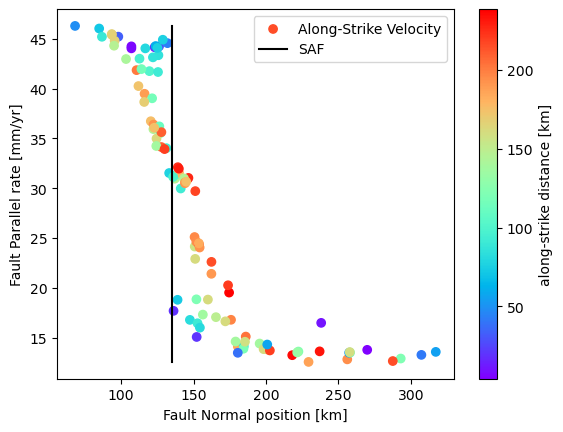

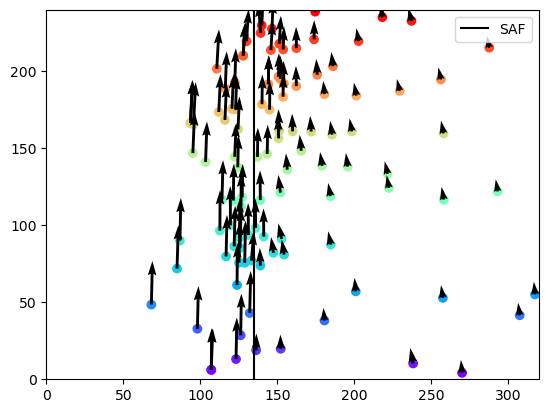

In [30]:
# we'll do this by plotting the y-component of position as a different color
# replot as a simple 1D transect
plt.scatter(
    x=GPSl["X"],
    y=GPSl["Yvel"] * 1e3,
    c=GPSl["Y"],
    cmap="rainbow",
    label="Along-Strike Velocity",
)
cbar = plt.colorbar()
cbar.ax.set_ylabel("along-strike distance [km]", rotation=90)
plt.plot(
    [fltOffset, fltOffset],
    [min(GPSl["Yvel"]) * 1e3, max(GPSl["Yvel"]) * 1e3],
    "k-",
    label="SAF",
)
plt.xlabel("Fault Normal position [km]")
plt.ylabel("Fault Parallel rate [mm/yr]")
plt.legend()
plt.show()

# plot results to make sure transformation is good
plt.scatter(x=GPSl["X"], y=GPSl["Y"], c=GPSl["Y"], cmap="rainbow")
plt.xlim([0, GPSend[0]])
plt.ylim([0, GPSend[1]])
plt.quiver(GPSl["X"], GPSl["Y"], GPSl["Xvel"], GPSl["Yvel"])
plt.plot([fltOffset, fltOffset], [0, GPSend[1]], "k-", label="SAF")
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
plt.legend()
plt.show()